In [10]:
# import necessary modules
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.neighbors.kde import KernelDensity



#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
filepath=os.path.join(os.getcwd(),filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g = 9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

# recreate the raw data using the eigenvector and transformed data
recreated_raw_data = np.reshape((np.dot(pca_transformed_data, pca.components_) + pca.mean_), (51, 41, 101))
recreated_raw_data_hist = np.reshape(recreated_raw_data,(nd_2, nd_4 * nd_5))

#get the time variable
times=Pressure_Levels_data.variables["time"]
#get the time number
date1=nc.num2date(times[:],units=times.units)
#get the time in date format
time=datetime.date(date1[0]).strftime("%Y-%m-%d %H:%M")

df = pd.DataFrame({'PC1':pca_transformed_data[:, 0],
                   'PC2':pca_transformed_data[:, 1]})

In [5]:
def bandwidth_selection(dataset,bandwidth):    
    significanceLower = int(51*0.3)
    outlierUpper = 2

    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(dataset)
    labels = meanshift.labels_

    from collections import Counter
    dicLabels=Counter(labels)

    sigModeNum=0
    outlierModeNum=0
    for i in dicLabels:
        if dicLabels[i] >= significanceLower:
            sigModeNum = sigModeNum + 1
        else:
            outlierModeNum = outlierModeNum + 1
    if outlierModeNum > outlierUpper:
            print("Number of outlier exceeds 2")
            print(labels)
    else:
        print("Number of sig mode is {0}".format(sigModeNum)) 
        print(labels)

In [6]:
bandwidth_selection(pca_transformed_data,26000)

Number of sig mode is 1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
def draw_density_plot_3D(dataset,bandwidth,lower,upper):    
    from mpl_toolkits.mplot3d import Axes3D
    kde=KernelDensity(kernel="gaussian",bandwidth=bandwidth).fit(dataset[:,lower:upper])

    X_plot = np.linspace(dataset[:,lower].min(),dataset[:,lower].max(),1000)
    Y_plot = np.linspace(dataset[:,upper-1].min(),dataset[:,upper-1].max(),1000)
    X,Y=np.meshgrid(X_plot,Y_plot)


    Xnew=np.reshape(X,(1000*1000))
    Ynew=np.reshape(Y,(1000*1000))
    new=np.vstack((Xnew, Ynew)).T

    log_dens = np.exp(kde.score_samples(new))
    lon_new = np.reshape(log_dens,(1000, 1000))

    #return lon_new
    fig=plt.figure()
    ax=fig.gca(projection="3d")
    ax.plot_surface(X,Y,lon_new)

In [8]:
def draw_density_plot_2D(x, y, bandwidth, xbins=1000j, ybins=1000j): 

    # create grid of sample locations
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

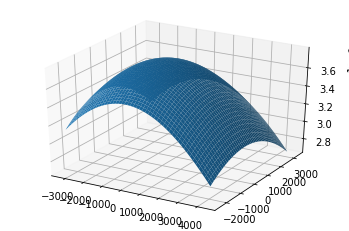

In [11]:
#%matplotlib notebook
draw_density_plot_3D(pca_transformed_data,6320,0,2)

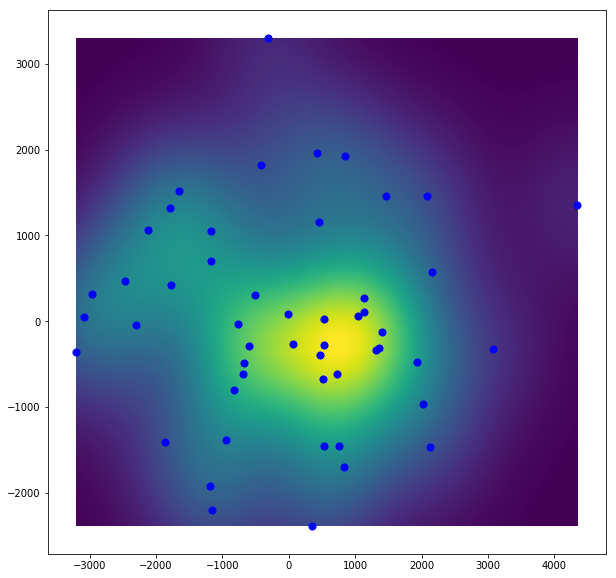

In [12]:
xx, yy, zz = draw_density_plot_2D(pca_transformed_data[:,0], pca_transformed_data[:,1], 664)
fig=plt.figure(figsize=(10,10))
ax=plt.gca()
p=ax.pcolormesh(xx, yy, zz)
ax.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], s=50, facecolor='blue')

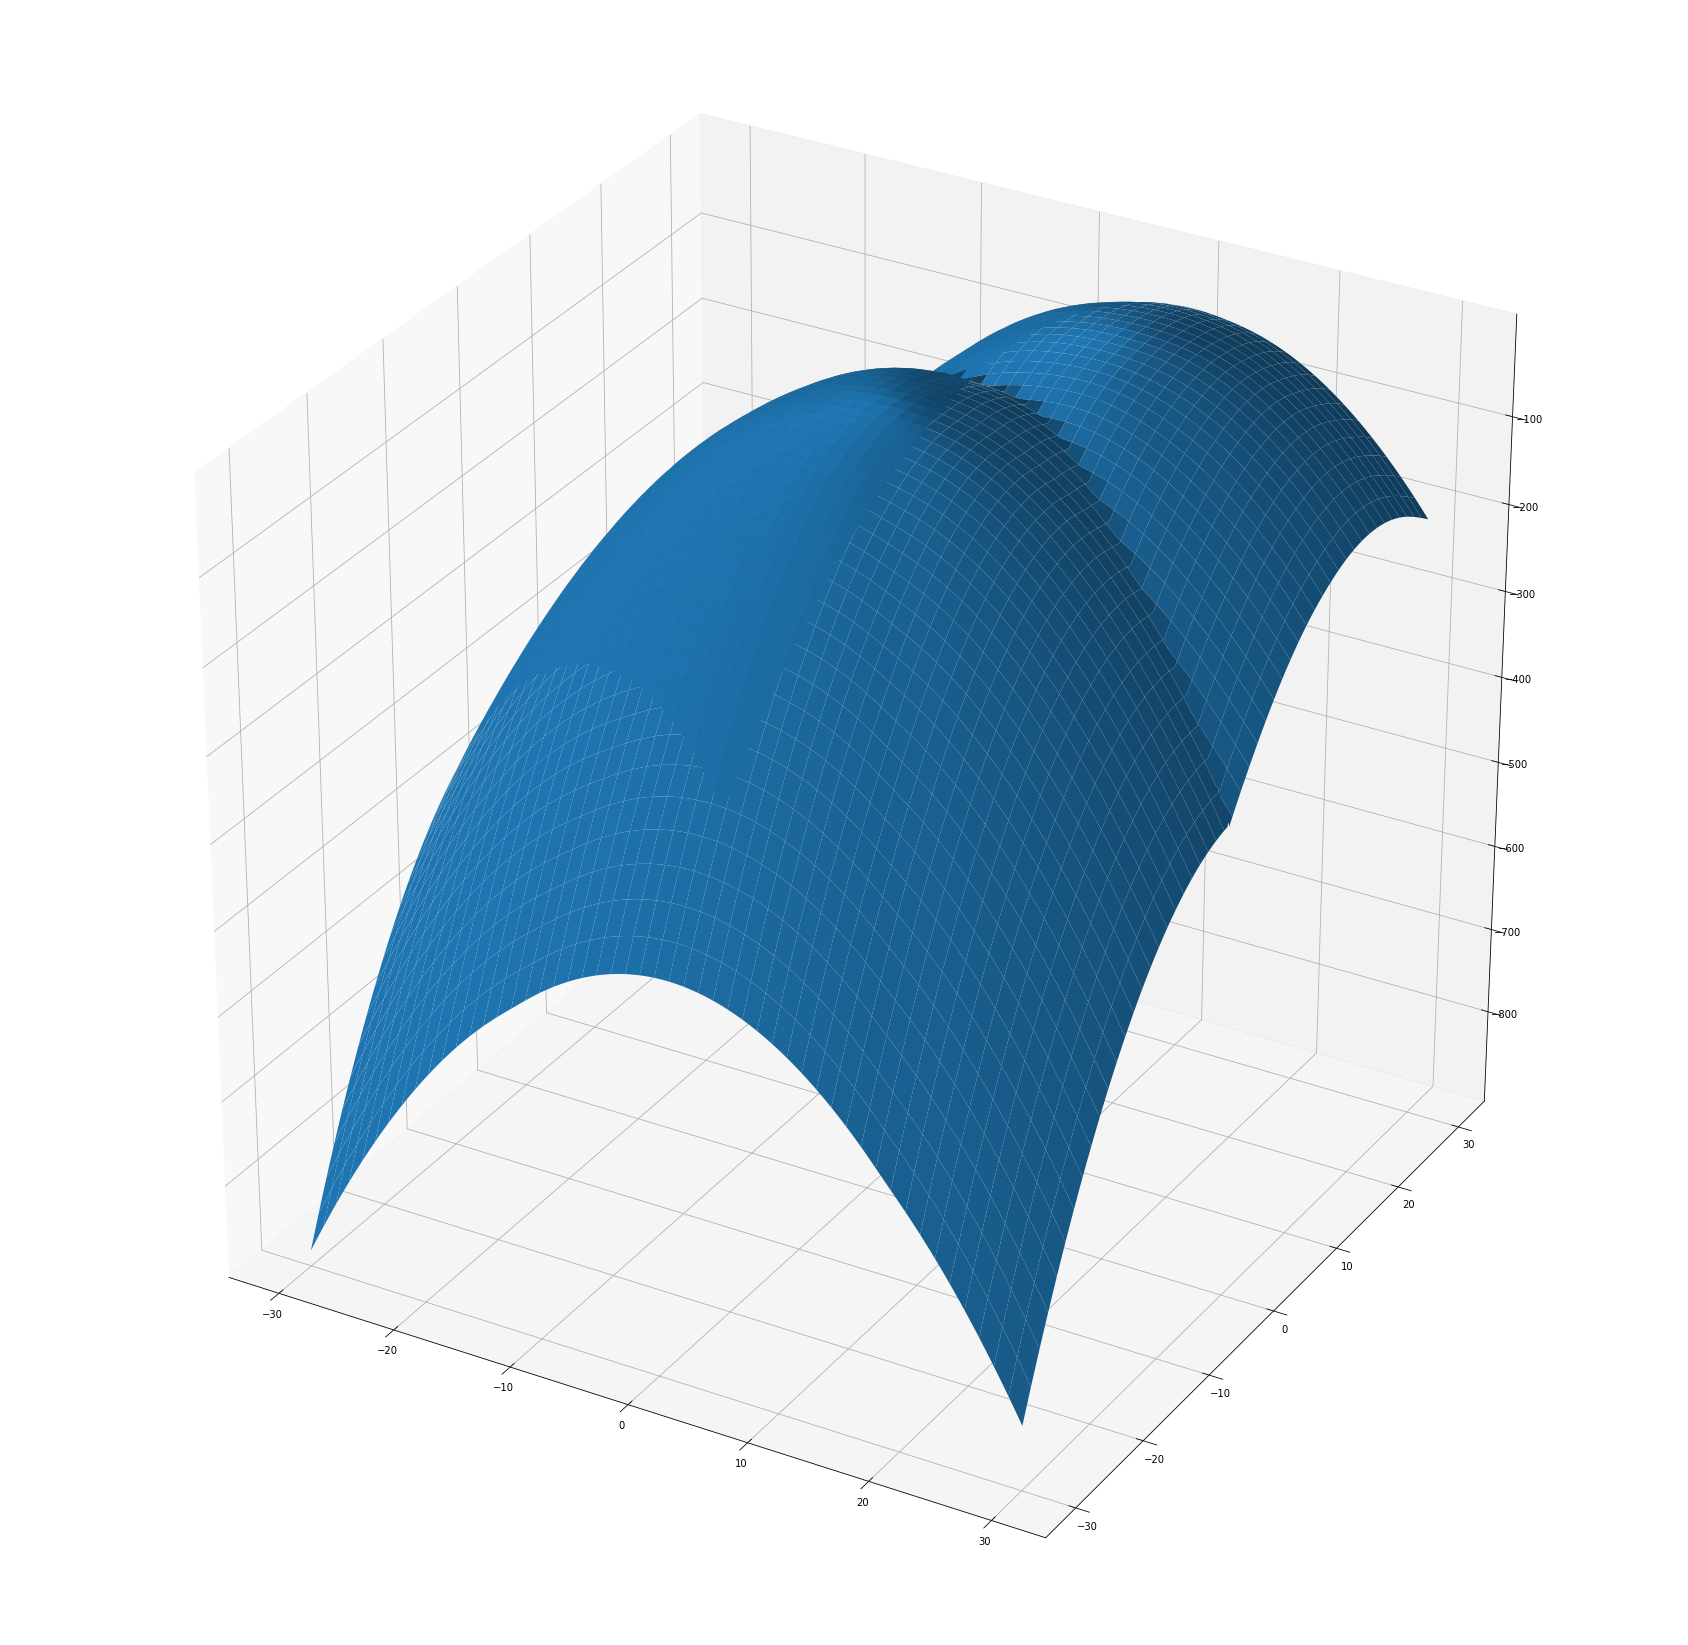

In [146]:
X1=np.random.multivariate_normal((1,2),[[1,0],[0,1]],(100))
X2=np.random.multivariate_normal((10,20),[[1,0],[0,1]],(100))
N=np.concatenate([X1,X2],axis=0)
kde1=KernelDensity(kernel="gaussian").fit(N)
Y_plot = np.linspace(-30,30, 1000)
X_plot = np.linspace(-30,30,1000)
X,Y=np.meshgrid(X_plot,Y_plot)
Xnew=np.reshape(X,(1000*1000))
Ynew=np.reshape(Y,(1000*1000))
new=np.vstack((Xnew, Ynew)).T
log_dens = kde1.score_samples(new)
lon_new = np.reshape(log_dens,(1000, 1000))
fig=plt.figure(figsize=(30,30))
ax=fig.gca(projection="3d")
ax.plot_surface(X,Y,lon_new)

In [103]:
from sklearn import preprocessing
# Get column names first
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(pca_transformed_data)

In [13]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace((pca_transformed_data[:,0]).min(), (pca_transformed_data[:,0]).max(), 1000)},cv=20) # 20-fold cross-validation
grid.fit(pca_transformed_data)
print(grid.best_params_)

{'bandwidth': 67.80435593063766}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
# Extract x and y
x = pca_transformed_data[:, 0]
y = pca_transformed_data[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

from scipy import stats as st
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values,bw_method=0.51)
f = np.reshape(kernel(positions).T, xx.shape)

-38796.54609375 49986.33515625 -29009.846484375 37960.123828125


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

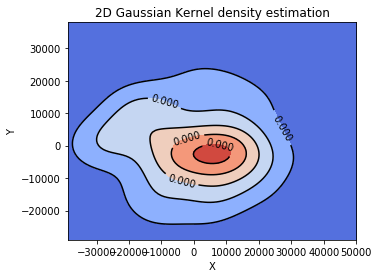

In [31]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

Text(0.5, 0.92, 'Surface plot of Gaussian 2D KDE')

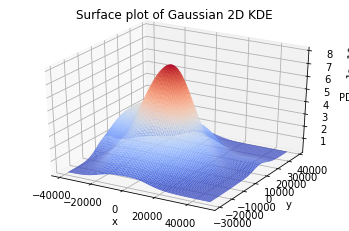

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')

<IPython.core.display.Javascript object>


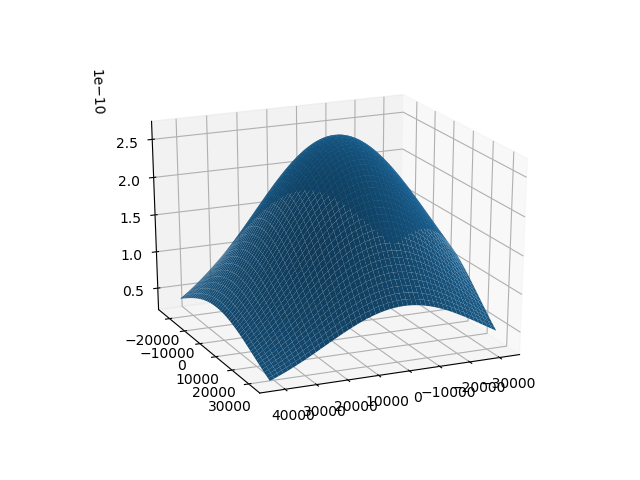

In [43]:
%matplotlib notebook
dataset=pca_transformed_data
lower=0
upper=2
kde=KernelDensity(kernel="gaussian",bandwidth=20000).fit(dataset[:,lower:upper])

X_plot = np.linspace(dataset[:,lower].min(),dataset[:,lower].max(),1000)
Y_plot = np.linspace(dataset[:,upper-1].min(),dataset[:,upper-1].max(),1000)
X,Y=np.meshgrid(X_plot,Y_plot)


Xnew=np.reshape(X,(1000*1000))
Ynew=np.reshape(Y,(1000*1000))
new=np.vstack((Xnew, Ynew)).T

log_dens = np.exp(kde.score_samples(new))
lon_new = np.reshape(log_dens,(1000, 1000))

#return lon_new
fig=plt.figure()
ax=fig.gca(projection="3d")
ax.plot_surface(X,Y,lon_new)

In [95]:
import math
PI = math.pi
def gaussianKernel(X):
    #from scipy.spatial import distance
    #return np.exp(-(math.sqrt(np.sum((x) ** 2)/2))) / math.sqrt(2*PI)
    return np.exp(-((np.linalg.norm(X)**2)/2))/math.sqrt(2*PI)
    
def scaledGaussianKernal(X,h,p):
    return gaussianKernel(X/h)/(h**p)

def kdeHD(dataset,index,bandwidth):
    #from scipy.spatial import distance
    return np.sum([scaledGaussianKernal(dataset[index]-dataset[i],bandwidth,dataset.ndim) for i in range(len(dataset))])/len(dataset)

In [86]:
gaussianKernel(pca_transformed_data[2]-pca_transformed_data[2])

0.3989422804014327

In [71]:
np.linalg.norm(pca_transformed_data[2]-pca_transformed_data[1])

44236.79

In [72]:
from scipy.spatial import distance
distance.euclidean(pca_transformed_data[2],pca_transformed_data[1])

44236.78515625

In [79]:
math.exp(-((np.linalg.norm(pca_transformed_data[50]-pca_transformed_data[1])**2)/2))

0.0

In [94]:
kdeHD(pca_transformed_data,25)

2.709674361328036e-10

In [96]:
[kdeHD(pca_transformed_data,i,6320) for i in range(51)]

[2.6354040464733315e-10,
 2.1255350505826296e-10,
 2.18205331079554e-10,
 2.1065716413872074e-10,
 2.1526969712299366e-10,
 2.240785189946145e-10,
 1.9694728657561103e-10,
 2.1280531939677603e-10,
 2.4047324007865056e-10,
 1.9935062234675272e-10,
 1.9697743191357477e-10,
 1.9882642106300184e-10,
 2.0023572469285024e-10,
 1.9694347932297628e-10,
 1.9923049445633924e-10,
 2.3340904363691617e-10,
 1.9928795753597508e-10,
 2.145904347055373e-10,
 1.9654799858000695e-10,
 1.9920725906241882e-10,
 2.0759336975513608e-10,
 2.2143984240399412e-10,
 2.797081648032988e-10,
 2.0001360268279023e-10,
 2.0122882638571155e-10,
 2.2415066503238597e-10,
 2.4208345437594774e-10,
 1.9667700977234594e-10,
 1.978085494837961e-10,
 2.139666146446648e-10,
 2.1097849556212033e-10,
 2.415419616281248e-10,
 1.9947925389274687e-10,
 1.9585212783230833e-10,
 2.0203931444050111e-10,
 2.3710915201999724e-10,
 2.415996617518818e-10,
 1.9585833784999376e-10,
 1.9694562669444152e-10,
 2.0273107240217638e-10,
 2.363649

In [89]:
np.exp(-978411848)

0.0

In [103]:
kde=KernelDensity(kernel="gaussian",bandwidth=6320).fit(pca_transformed_data[:,0][:,np.newaxis])

In [104]:
X_plot = np.linspace(pca_transformed_data[:,0].min(),pca_transformed_data[:,0].max(),1000)

In [107]:
np.exp(kde.score_samples(X_plot[:,np.newaxis]))

array([5.49385308e-06, 5.53640109e-06, 5.57892291e-06, 5.62141683e-06,
       5.66388121e-06, 5.70631452e-06, 5.74871530e-06, 5.79108222e-06,
       5.83341400e-06, 5.87570948e-06, 5.91796759e-06, 5.96018734e-06,
       6.00236785e-06, 6.04450831e-06, 6.08660803e-06, 6.12866639e-06,
       6.17068287e-06, 6.21265704e-06, 6.25458856e-06, 6.29647718e-06,
       6.33832274e-06, 6.38012518e-06, 6.42188450e-06, 6.46360081e-06,
       6.50527430e-06, 6.54690524e-06, 6.58849398e-06, 6.63004098e-06,
       6.67154674e-06, 6.71301186e-06, 6.75443703e-06, 6.79582300e-06,
       6.83717060e-06, 6.87848074e-06, 6.91975438e-06, 6.96099259e-06,
       7.00219647e-06, 7.04336721e-06, 7.08450605e-06, 7.12561432e-06,
       7.16669338e-06, 7.20774467e-06, 7.24876968e-06, 7.28976996e-06,
       7.33074711e-06, 7.37170278e-06, 7.41263868e-06, 7.45355657e-06,
       7.49445823e-06, 7.53534550e-06, 7.57622028e-06, 7.61708447e-06,
       7.65794005e-06, 7.69878900e-06, 7.73963335e-06, 7.78047515e-06,
      

In [14]:
pca_transformed_data[:,0]

array([  -104.2384, -30182.402 ,   8095.6885,   5251.0405,  -5049.6763,
         4608.997 , -11585.203 ,  -5925.273 ,  11177.127 , -31397.969 ,
        30164.586 ,   4220.085 ,  -6786.173 , -20753.48  ,  11066.825 ,
       -11455.002 ,  20475.88  , -24202.64  ,   8342.839 ,  21160.074 ,
       -11545.314 ,  13755.963 ,    558.3138, -17364.16  ,  -4051.0488,
       -16205.16  ,   7439.2324,   7081.68  ,  14366.165 , -29064.4   ,
        19867.598 ,  -6620.9834,   5243.8286,  42587.76  ,   4484.1797,
         5229.6675,  -7484.5806, -18309.61  ,  18901.97  ,  -8102.003 ,
        13386.363 , -11358.347 ,  10162.648 ,   3477.2227,  -9291.182 ,
        12886.919 , -22567.662 ,  20921.512 ,  -3008.6711, -17515.64  ,
         5016.665 ], dtype=float32)

In [24]:
pca.components_[0]

array([-0.01235362, -0.012226  , -0.01196883, ..., -0.00153125,
       -0.00162149, -0.00163482], dtype=float32)